In [5]:
import numpy as np
from numpy import mean,std

import pandas as pd

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,ZeroPadding2D
from keras.datasets import mnist
from keras.utils import to_categorical,plot_model
from keras.optimizers import SGD,Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model,Model
from keras.backend import placeholder
import h5py
from zipfile import ZipFile
import pydot

Create a looping function to define the convolution layers that are used in the VGG Block. 
Each layer is filtered by using same number of filters and filter size followed by same padding to maintain the size of the input volume.After that, the activation relu is applied and Then the Max pooling is performed with 2x2 size.

In [6]:
def vgg_layer(X1,n_filters,n_conv):
    
    (pix,pix,nC) = X1.shape[1:]
    X_input = Input((pix,pix,nC))
    
    for _ in range(1,n_conv):
        
        X = ZeroPadding2D((3,3))(X_input)
        
        X = Conv2D(n_filters,(3,3),padding = 'same',strides = (2,2),activation = 'relu',kernel_initializer = 'glorot_uniform',input_shape = (pix,pix,nC))(X)
        
        X = MaxPooling2D(pool_size = (2,2),strides = (2,2),padding = 'same')(X)
        
        
        return X_input,X
        

connect the volume of the data to 2 layers of FC Dense layers together with a softmax function to predict the classification

In [7]:
def FC_layer(X,nL):
    
    X = Flatten()(X)
    
    X = Dense(100,activation = 'relu',use_bias = True,kernel_initializer = 'glorot_uniform')(X)
    
    X = Dense(80,activation = 'relu',use_bias = True,kernel_initializer = 'glorot_uniform')(X)

    X = Dense(nL,activation = 'softmax')(X)
    
    return X

Initialize the inputs and gather all functions into VGG Model

2


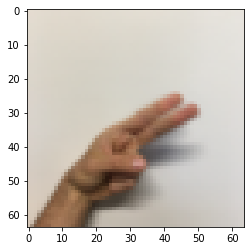

In [8]:
TrainDataset = h5py.File('train_handsignals.h5','r')
TestDataset = h5py.File('test_handsignals.h5','r')

X_train = np.array(TrainDataset['train_set_x'][:])
X_test = np.array(TestDataset['test_set_x'][:])

Y_train = np.array(TrainDataset['train_set_y'][:])
Y_test = np.array(TestDataset['test_set_y'][:])

#sample image check
idx = 2
plt.imshow(X_train[idx])
print(Y_train[idx])



In [9]:
m = X_train.shape[0]
pix = X_train.shape[1]
nC = X_train.shape[3]
nL = len(np.unique(Y_train))
n_filters = 64
n_conv = 3

In [10]:
def data_reshape(X1,X2,Y1,Y2,nC,numLabels):
    
    
    pix = X1.shape[1]
    
    X1 = X1.reshape(-1,pix,pix,nC)
    X2 = X2.reshape(-1,pix,pix,nC)
    

    Y1 = Y1.reshape(-1,1)
    Y2 = Y2.reshape(-1,1)
    
    Y1_oh = to_categorical(Y1,numLabels)
    Y2_oh = to_categorical(Y2,numLabels)
    
    X1_norm = (X1/255.0).astype('float32')
    X2_norm = (X2/255.0).astype('float32')
    
    return Y1_oh,Y2_oh,X1_norm,X2_norm

In [11]:
def Model_VGG(X1,X2,Y1,Y2,nC,nL,n_filters,n_conv):
    
    Y1_oh,Y2_oh,X1_norm,X2_norm = data_reshape(X1,X2,Y1,Y2,nC,nL)
    
    X_input,X = vgg_layer(X1,n_filters,n_conv)
    
    X = FC_layer(X,nL)
    
    model = Model(inputs = X_input,outputs = X)
    
    opt = Adam(learning_rate = 0.001)
    
    model.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics = ['accuracy'])
    
    return Y1_oh,Y2_oh,X1_norm,X2_norm,model


    

In [12]:
Y_train_oh,Y_test_oh,X_train_norm,X_test_norm,model = Model_VGG(X_train,X_test,Y_train,Y_test,nC,nL,n_filters,n_conv)


Epoch 1/20
1080/1080 [==============================] - 5s 5ms/step - loss: 1.8322 - accuracy: 0.1926
Epoch 2/20
1080/1080 [==============================] - 4s 4ms/step - loss: 1.6513 - accuracy: 0.4204
Epoch 3/20
1080/1080 [==============================] - 4s 4ms/step - loss: 1.3052 - accuracy: 0.5417
Epoch 4/20
1080/1080 [==============================] - 4s 4ms/step - loss: 0.9888 - accuracy: 0.6287
Epoch 5/20
1080/1080 [==============================] - 4s 4ms/step - loss: 0.7177 - accuracy: 0.7556
Epoch 6/20
1080/1080 [==============================] - 4s 4ms/step - loss: 0.5852 - accuracy: 0.7981
Epoch 7/20
1080/1080 [==============================] - 4s 4ms/step - loss: 0.4988 - accuracy: 0.8370
Epoch 8/20
1080/1080 [==============================] - 5s 4ms/step - loss: 0.3937 - accuracy: 0.8917
Epoch 9/20
1080/1080 [==============================] - 5s 4ms/step - loss: 0.3043 - accuracy: 0.9231
Epoch 10/20
1080/1080 [==============================] - 5s 5ms/step - loss: 0.22

Text(0, 0.5, 'loss')

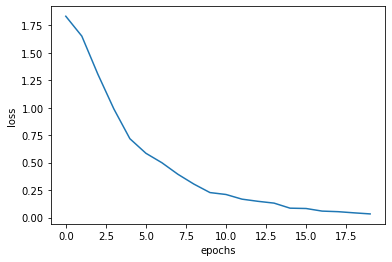

In [13]:
history = model.fit(X_train_norm,Y_train_oh,epochs = 20,batch_size = 32)
model.save('model_vgg.h5')
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [14]:
_,test_accuracy = model.evaluate(X_test_norm,Y_test_oh)
print('Test Accuracy :',(100*test_accuracy))
predictions = model.predict(X_test_norm);
pred = [round(x[0]) for x in predictions]  

120/120 [==============================] - 1s 5ms/step
Test Accuracy : 92.5000011920929


In [15]:
def load_image(image_file,pix):
    
    img = load_img(image_file,target_size = ((pix,pix)))
    img = img_to_array(img)
    img = img.reshape(1,pix,pix,3)
    img = img.astype('float32')
    img = img/255.0
    
    return img


In [16]:
img = load_image('allu_fingers.jpg',pix)
model = load_model('final_model.h5')
#digit = model.predict_classes(img)  # for sequential models
digit = np.argmax(model.predict(img))  #for model based models
print(digit)


4


In [17]:
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 6, 6, 64)          0  

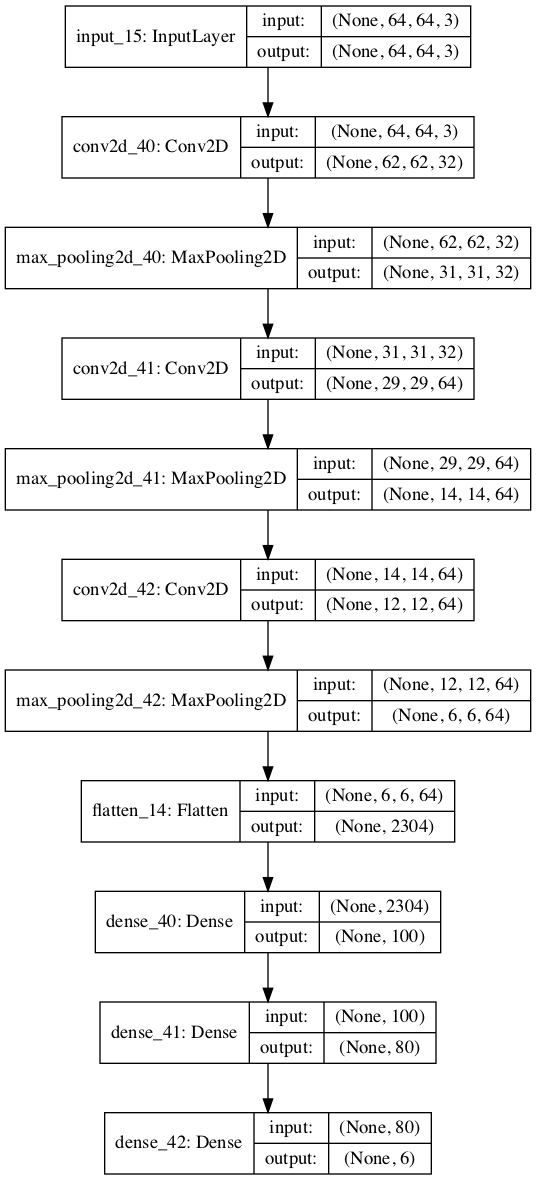

In [18]:
plot_model(model, show_shapes=True, to_file='vgg_block.png')